# **Atividade - Uso de Redes Neurais Profundas**

## **Disciplina:** CAP-421-3 Aprendizado Profundo

**Discintes:**

Gabriel Sansigolo

### **Importando bibliotecas**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

from torchinfo import summary

### **Utiliza GPU (cuda), caso contrário, utiliza CPU**

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# *VGG19*

In [3]:
path_dir = os.path.dirname("")

df_treinamento_vgg19 = pd.read_csv(os.path.join(path_dir, "deep_learning/vgg19/treinamento_vgg19.csv"), low_memory=False)
df_treinamento_vgg19 = df_treinamento_vgg19.reset_index()  
df_treinamento_vgg19=df_treinamento_vgg19.drop(df_treinamento_vgg19.index[:2])

df_teste_vgg19 = pd.read_csv(os.path.join(path_dir, "deep_learning/vgg19/teste_vgg19.csv"), low_memory=False)
df_teste_vgg19 = df_teste_vgg19.reset_index()  
df_teste_vgg19=df_teste_vgg19.drop(df_teste_vgg19.index[:2])

In [4]:
X_train = []
y_train = []
X_test = []
y_test = []

### **(VGG19) 1 - Dividindo os dados (treinamento e teste)**

In [5]:
new_df_treinamento_vgg19 = df_treinamento_vgg19.drop('category', axis=1)
new_df_treinamento_vgg19 = new_df_treinamento_vgg19.astype(np.float32)
X_train_tensor = torch.tensor(new_df_treinamento_vgg19.values)

for row in df_treinamento_vgg19.itertuples(index=False, name='Pandas'):
    y_train.append(0 if row.category == "NaoPistas" else 1)
    
new_df_teste_vgg19 = df_teste_vgg19.drop('category', axis=1)
new_df_teste_vgg19 = new_df_teste_vgg19.astype(np.float32)
X_test_tensor = torch.tensor(new_df_teste_vgg19.values)

for row in df_teste_vgg19.itertuples(index=False, name='Pandas'):
    y_test.append(0 if row.category == "NaoPistas" else 1)

In [6]:
y_train_tensor = torch.tensor(y_train, device=device) 
y_test_tensor = torch.tensor(y_test,  device=device) 

### **(VGG19) 2 - Verificação das Dimensões dos Dados de Treinamento e Teste**

In [7]:
print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([19622, 1001])
torch.Size([19622])
torch.Size([2465, 1001])
torch.Size([2465])


### **(VGG19) 3 - Definindo a Rede Neural Convolucional (CNN) para Classificação**

In [8]:
n_timesteps, n_features, n_outputs = X_train_tensor.shape[0], X_train_tensor.shape[1], y_train_tensor.shape[0]

In [9]:
class ConvNet1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(n_features, n_features, kernel_size=30),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(10))
        self.layer2 = nn.Flatten()
        self.layer3 = nn.Sequential(
            nn.Linear(97,100),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(100,2),
            nn.Softmax(dim=1))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

In [10]:
model = ConvNet1D().to(device)

In [11]:
summary(model)

Layer (type:depth-idx)                   Param #
ConvNet1D                                --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       30,061,031
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─MaxPool1d: 2-4                    --
├─Flatten: 1-2                           --
├─Sequential: 1-3                        --
│    └─Linear: 2-5                       9,800
│    └─ReLU: 2-6                         --
├─Sequential: 1-4                        --
│    └─Linear: 2-7                       202
│    └─Softmax: 2-8                      --
Total params: 30,071,033
Trainable params: 30,071,033
Non-trainable params: 0

### **(VGG19) 4 - Definição da Função de Perda e do Otimizador**

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### **(VGG19) 5 - Hiperparâmetros**

In [13]:
num_epochs = 10
total_step = X_train_tensor.shape[0]

### **(VGG19) 6 - Treinamento do Modelo CNN e Avaliação do Desempenho**

In [14]:
loss_list = []
acc_list = []
acc_list_epoch = []
batch_size = 1001

for epoch in range(num_epochs):
    correct_sum = 0
    for i in range(int(np.floor(total_step/batch_size))): # split data into batches
        trainXT_seg = X_train_tensor[i*batch_size:(i+1)*batch_size]
        trainyT_seg = y_train_tensor[i*batch_size:(i+1)*batch_size]
        # Run the forward pass
        outputs = model(trainXT_seg)
        loss = criterion(outputs, trainyT_seg)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Track the accuracy
        total = trainyT_seg.size(0)
        _, predicted = torch.max(outputs, -1)
        _, actual = torch.max(trainyT_seg, -1)
        correct = (predicted == actual).sum().item()
        correct_sum = correct_sum + (correct/total)
        acc_list.append(correct / total)

    acc_list_epoch.append(correct_sum/int(np.floor(total_step/batch_size)))
    print(f'Epoch: {epoch} \t|' \
        f' Train loss: {np.round(loss.item(),5)} \t|' \
        f' Train acc: {np.round(correct_sum/int(np.floor(total_step/batch_size)),4)} \t|')

Epoch: 0 	| Train loss: 1.24019 	| Train acc: 0.9427 	|
Epoch: 1 	| Train loss: 1.23835 	| Train acc: 0.9474 	|
Epoch: 2 	| Train loss: 1.24691 	| Train acc: 0.9474 	|
Epoch: 3 	| Train loss: 1.24667 	| Train acc: 0.9474 	|
Epoch: 4 	| Train loss: 1.25075 	| Train acc: 0.9474 	|
Epoch: 5 	| Train loss: 1.25527 	| Train acc: 0.9474 	|
Epoch: 6 	| Train loss: 1.26295 	| Train acc: 0.9474 	|
Epoch: 7 	| Train loss: 1.26547 	| Train acc: 0.9474 	|
Epoch: 8 	| Train loss: 1.27142 	| Train acc: 0.9474 	|
Epoch: 9 	| Train loss: 1.27688 	| Train acc: 0.9474 	|


### **(VGG19) 7 - Visualização da Curva de Acurácia**

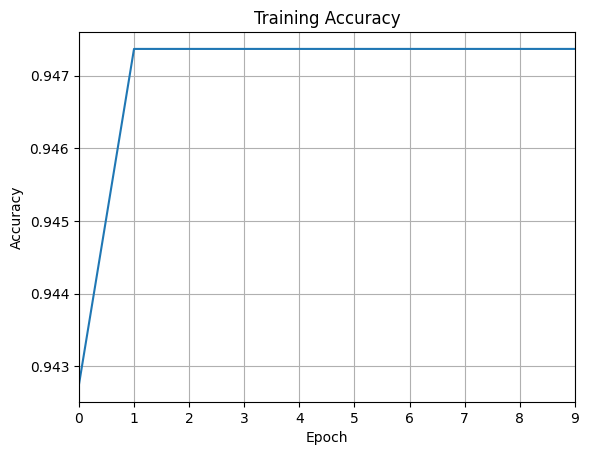

In [15]:
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(acc_list_epoch)
plt.show()

### **(VGG19) 8 - Rodando a rede nos dados de validação**

In [16]:
df_todas_vgg19 = pd.read_csv(os.path.join(path_dir, "deep_learning/vgg19/todas_vgg19.csv"), low_memory=False)
df_todas_vgg19 = df_todas_vgg19.reset_index()  
df_todas_vgg19 = df_todas_vgg19.drop(df_todas_vgg19.index[:2])

In [17]:
new_df_todas_vgg19 = df_todas_vgg19.astype(np.float32)
X_validation_tensor = torch.tensor(new_df_todas_vgg19.values)

In [18]:
print(X_validation_tensor.shape)

torch.Size([44033, 1001])


In [19]:
predicts = []
batch_size = 1001

for epoch in range(num_epochs):
    correct_sum = 0
    for i in range(int(np.floor(total_step/batch_size))): # split data into batches
        validationXT_seg = X_validation_tensor[i*batch_size:(i+1)*batch_size]
        outputs = model(validationXT_seg)
        total = validationXT_seg.size(0)
        _, predicted = torch.max(outputs, -1)
        predicts.append(predicted)

predicts[:5]

[tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([0, 0, 0,  ..., 0, 0, 0])]

# *Squeezenet*

In [20]:
path_dir = os.path.dirname("")

df_treinamento_squeezenet = pd.read_csv(os.path.join(path_dir, "deep_learning/squeezenet/treinamento_squeezenet.csv"), low_memory=False)
df_treinamento_squeezenet = df_treinamento_squeezenet.reset_index()  
df_treinamento_squeezenet=df_treinamento_squeezenet.drop(df_treinamento_squeezenet.index[:2])

df_teste_squeezenet = pd.read_csv(os.path.join(path_dir, "deep_learning/squeezenet/teste_squeezenet.csv"), low_memory=False)
df_teste_squeezenet = df_teste_squeezenet.reset_index()  
df_teste_squeezenet=df_teste_squeezenet.drop(df_teste_squeezenet.index[:2])

### **(Squeezenet) 1 - Dividindo os dados (treinamento e teste)**

In [21]:
new_df_treinamento_squeezenet = df_treinamento_squeezenet.drop('category', axis=1)
new_df_treinamento_squeezenet = new_df_treinamento_squeezenet.astype(np.float32)
X_train_tensor = torch.tensor(new_df_treinamento_squeezenet.values)

for row in df_treinamento_squeezenet.itertuples(index=False, name='Pandas'):
    y_train.append(0 if row.category == "NaoPistas" else 1)
    
new_df_teste_squeezenet = df_teste_squeezenet.drop('category', axis=1)
new_df_teste_squeezenet = new_df_teste_squeezenet.astype(np.float32)
X_test_tensor = torch.tensor(new_df_teste_squeezenet.values)

for row in df_teste_squeezenet.itertuples(index=False, name='Pandas'):
    y_test.append(0 if row.category == "NaoPistas" else 1)

In [22]:
y_train_tensor = torch.tensor(y_train, device=device) 
y_test_tensor = torch.tensor(y_test,  device=device) 

### **(Squeezenet) 2 - Verificação das Dimensões dos Dados de Treinamento e Teste**

In [23]:
print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([19622, 1001])
torch.Size([39244])
torch.Size([2465, 1001])
torch.Size([4930])


### **(Squeezenet) 3 - Definindo a Rede Neural Convolucional (CNN) para Classificação**

In [24]:
n_timesteps, n_features, n_outputs = X_train_tensor.shape[0], X_train_tensor.shape[1], y_train_tensor.shape[0]

In [25]:
class ConvNet1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(n_features, n_features, kernel_size=30),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(10))
        self.layer2 = nn.Flatten()
        self.layer3 = nn.Sequential(
            nn.Linear(97,700),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(700,2),
            nn.Softmax(dim=1))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

In [26]:
model = ConvNet1D().to(device)

In [27]:
summary(model)

Layer (type:depth-idx)                   Param #
ConvNet1D                                --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       30,061,031
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─MaxPool1d: 2-4                    --
├─Flatten: 1-2                           --
├─Sequential: 1-3                        --
│    └─Linear: 2-5                       68,600
│    └─ReLU: 2-6                         --
├─Sequential: 1-4                        --
│    └─Linear: 2-7                       1,402
│    └─Softmax: 2-8                      --
Total params: 30,131,033
Trainable params: 30,131,033
Non-trainable params: 0

### **(Squeezenet) 4 - Definição da Função de Perda e do Otimizador**

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### **(Squeezenet) 5 - Hiperparâmetros**

In [29]:
num_epochs = 10
total_step = X_train_tensor.shape[0]

### **(Squeezenet) 6 - Treinamento do Modelo CNN e Avaliação do Desempenho**

In [30]:
loss_list = []
acc_list = []
acc_list_epoch = []
batch_size = 1001

for epoch in range(num_epochs):
    correct_sum = 0
    for i in range(int(np.floor(total_step/batch_size))): # split data into batches
        trainXT_seg = X_train_tensor[i*batch_size:(i+1)*batch_size]
        trainyT_seg = y_train_tensor[i*batch_size:(i+1)*batch_size]
        # Run the forward pass
        outputs = model(trainXT_seg)
        loss = criterion(outputs, trainyT_seg)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Track the accuracy
        total = trainyT_seg.size(0)
        _, predicted = torch.max(outputs, -1)
        _, actual = torch.max(trainyT_seg, -1)
        correct = (predicted == actual).sum().item()
        correct_sum = correct_sum + (correct/total)
        acc_list.append(correct / total)

    acc_list_epoch.append(correct_sum/int(np.floor(total_step/batch_size)))
    print(f'Epoch: {epoch} \t|' \
        f' Train loss: {np.round(loss.item(),5)} \t|' \
        f' Train acc: {np.round(correct_sum/int(np.floor(total_step/batch_size)),4)} \t|')

Epoch: 0 	| Train loss: 1.19196 	| Train acc: 0.9297 	|
Epoch: 1 	| Train loss: 1.22089 	| Train acc: 0.9474 	|
Epoch: 2 	| Train loss: 1.24572 	| Train acc: 0.9474 	|
Epoch: 3 	| Train loss: 1.26243 	| Train acc: 0.9474 	|
Epoch: 4 	| Train loss: 1.27528 	| Train acc: 0.9474 	|
Epoch: 5 	| Train loss: 1.28573 	| Train acc: 0.9474 	|
Epoch: 6 	| Train loss: 1.29181 	| Train acc: 0.9474 	|
Epoch: 7 	| Train loss: 1.2972 	| Train acc: 0.9474 	|
Epoch: 8 	| Train loss: 1.29963 	| Train acc: 0.9474 	|
Epoch: 9 	| Train loss: 1.30212 	| Train acc: 0.9474 	|


### **(Squeezenet) 7 - Visualização da Curva de Acurácia**

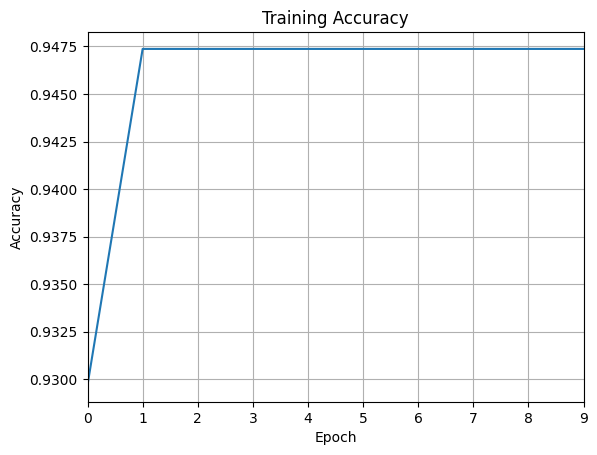

In [31]:
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(acc_list_epoch)
plt.show()

### **(Squeezenet) 8 - Rodando a rede nos dados de validação**

In [32]:
df_todas_squeezenet = pd.read_csv(os.path.join(path_dir, "deep_learning/squeezenet/todas_squeezenet.csv"), low_memory=False)
df_todas_squeezenet = df_todas_squeezenet.reset_index()  
df_todas_squeezenet = df_todas_squeezenet.drop(df_todas_squeezenet.index[:2])

In [33]:
new_df_todas_squeezenet = df_todas_squeezenet.astype(np.float32)
X_validation_tensor = torch.tensor(new_df_todas_squeezenet.values)

In [34]:
print(X_validation_tensor.shape)

torch.Size([25889, 1001])


In [35]:
predicts = []
batch_size = 1001

for epoch in range(num_epochs):
    correct_sum = 0
    for i in range(int(np.floor(total_step/batch_size))): # split data into batches
        validationXT_seg = X_validation_tensor[i*batch_size:(i+1)*batch_size]
        outputs = model(validationXT_seg)
        total = validationXT_seg.size(0)
        _, predicted = torch.max(outputs, -1)
        predicts.append(predicted)

predicts[:5]

[tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([0, 0, 0,  ..., 0, 0, 0])]

# *Painters*

In [36]:
path_dir = os.path.dirname("")

df_treinamento_painters = pd.read_csv(os.path.join(path_dir, "deep_learning/painters/treinamento_painters.csv"), low_memory=False)
df_treinamento_painters = df_treinamento_painters.reset_index()  
df_treinamento_painters=df_treinamento_painters.drop(df_treinamento_painters.index[:2])

df_teste_painters = pd.read_csv(os.path.join(path_dir, "deep_learning/painters/teste_painters.csv"), low_memory=False)
df_teste_painters = df_teste_painters.reset_index()  
df_teste_painters=df_teste_painters.drop(df_teste_painters.index[:2])

### **(Painters) 1 - Dividindo os dados (treinamento e teste)**

In [37]:
new_df_treinamento_painters = df_treinamento_painters.drop('category', axis=1)
new_df_treinamento_painters = new_df_treinamento_painters.astype(np.float32)
X_train_tensor = torch.tensor(new_df_treinamento_painters.values)

for row in df_treinamento_painters.itertuples(index=False, name='Pandas'):
    y_train.append(0 if row.category == "NaoPistas" else 1)
    
new_df_teste_painters = df_teste_painters.drop('category', axis=1)
new_df_teste_painters = new_df_teste_painters.astype(np.float32)
X_test_tensor = torch.tensor(new_df_teste_painters.values)

for row in df_teste_painters.itertuples(index=False, name='Pandas'):
    y_test.append(0 if row.category == "NaoPistas" else 1)

In [38]:
y_train_tensor = torch.tensor(y_train, device=device) 
y_test_tensor = torch.tensor(y_test,  device=device) 

### **(Painters) 2 - Verificação das Dimensões dos Dados de Treinamento e Teste**

In [39]:
print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([19622, 2049])
torch.Size([58866])
torch.Size([2465, 2049])
torch.Size([7395])


### **(Painters) 3 - Definindo a Rede Neural Convolucional (CNN) para Classificação**

In [40]:
n_timesteps, n_features, n_outputs = X_train_tensor.shape[0], X_train_tensor.shape[1], y_train_tensor.shape[0]

In [41]:
class ConvNet1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(n_features, n_features, kernel_size=30),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(10))
        self.layer2 = nn.Flatten()
        self.layer3 = nn.Sequential(
            nn.Linear(202,100),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(100,2),
            nn.Softmax(dim=1))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

In [42]:
model = ConvNet1D().to(device)

In [43]:
summary(model)

Layer (type:depth-idx)                   Param #
ConvNet1D                                --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       125,954,079
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─MaxPool1d: 2-4                    --
├─Flatten: 1-2                           --
├─Sequential: 1-3                        --
│    └─Linear: 2-5                       20,300
│    └─ReLU: 2-6                         --
├─Sequential: 1-4                        --
│    └─Linear: 2-7                       202
│    └─Softmax: 2-8                      --
Total params: 125,974,581
Trainable params: 125,974,581
Non-trainable params: 0

### **(Painters) 4 - Definição da Função de Perda e do Otimizador**

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### **(Painters) 5 - Hiperparâmetros**

In [45]:
num_epochs = 10
total_step = X_train_tensor.shape[0]

### **(Painters) 6 - Treinamento do Modelo CNN e Avaliação do Desempenho**

In [46]:
loss_list = []
acc_list = []
acc_list_epoch = []
batch_size = 2049

for epoch in range(num_epochs):
    correct_sum = 0
    for i in range(int(np.floor(total_step/batch_size))): # split data into batches
        trainXT_seg = X_train_tensor[i*batch_size:(i+1)*batch_size]
        trainyT_seg = y_train_tensor[i*batch_size:(i+1)*batch_size]
        # Run the forward pass
        outputs = model(trainXT_seg)
        loss = criterion(outputs, trainyT_seg)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Track the accuracy
        total = trainyT_seg.size(0)
        _, predicted = torch.max(outputs, -1)
        _, actual = torch.max(trainyT_seg, -1)
        correct = (predicted == actual).sum().item()
        correct_sum = correct_sum + (correct/total)
        acc_list.append(correct / total)

    acc_list_epoch.append(correct_sum/int(np.floor(total_step/batch_size)))
    print(f'Epoch: {epoch} \t|' \
        f' Train loss: {np.round(loss.item(),5)} \t|' \
        f' Train acc: {np.round(correct_sum/int(np.floor(total_step/batch_size)),4)} \t|')

Epoch: 0 	| Train loss: 1.31229 	| Train acc: 0.8614 	|
Epoch: 1 	| Train loss: 1.31229 	| Train acc: 0.8889 	|
Epoch: 2 	| Train loss: 1.31229 	| Train acc: 0.8889 	|
Epoch: 3 	| Train loss: 1.31229 	| Train acc: 0.8889 	|
Epoch: 4 	| Train loss: 1.31229 	| Train acc: 0.8889 	|
Epoch: 5 	| Train loss: 1.31229 	| Train acc: 0.8889 	|
Epoch: 6 	| Train loss: 1.31229 	| Train acc: 0.8889 	|
Epoch: 7 	| Train loss: 1.31229 	| Train acc: 0.8889 	|
Epoch: 8 	| Train loss: 1.31229 	| Train acc: 0.8889 	|
Epoch: 9 	| Train loss: 1.31229 	| Train acc: 0.8889 	|


### **(Painters) 7 - Visualização da Curva de Acurácia**

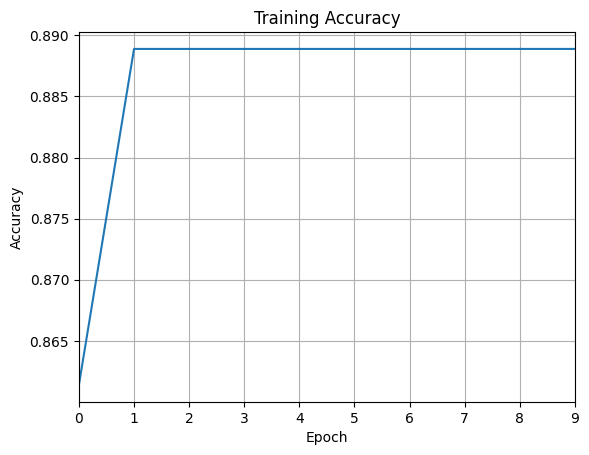

In [47]:
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(acc_list_epoch)
plt.show()

### **(Painters) 8 - Rodando a rede nos dados de validação**

In [48]:
df_todas_painters = pd.read_csv(os.path.join(path_dir, "deep_learning/painters/todas_painters.csv"), low_memory=False)
df_todas_painters = df_todas_painters.reset_index()  
df_todas_painters = df_todas_painters.drop(df_todas_painters.index[:2])

In [49]:
new_df_todas_painters = df_todas_painters.astype(np.float32)
X_validation_tensor = torch.tensor(new_df_todas_painters.values)

In [50]:
print(X_validation_tensor.shape)

torch.Size([44033, 2049])


In [52]:
predicts = []
batch_size = 2049

for epoch in range(num_epochs):
    correct_sum = 0
    for i in range(int(np.floor(total_step/batch_size))): # split data into batches
        validationXT_seg = X_validation_tensor[i*batch_size:(i+1)*batch_size]
        outputs = model(validationXT_seg)
        total = validationXT_seg.size(0)
        _, predicted = torch.max(outputs, -1)
        predicts.append(predicted)

predicts[:5]

[tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([0, 0, 0,  ..., 0, 0, 0])]